## Analysis of PLIER latent space representations vs. other methods

First, we want to compare the sparsity of the different methods. If PLIER is learning a distinct alignment of latent space weights to pathways, we would expect its weights to be sparser (more zeros relative to size) than the other methods, which are pathway-agnostic.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import config as cfg

In [2]:
z_dims = [10, 20, 50, 100, 200]
models_map = {
    'pca': os.path.abspath(os.path.join(cfg.models_dir, 'canonical_pathways', 'ensemble_z_matrices')),
    'ica': os.path.abspath(os.path.join(cfg.models_dir, 'canonical_pathways', 'ensemble_z_matrices')),
    'nmf': os.path.abspath(os.path.join(cfg.models_dir, 'canonical_pathways', 'ensemble_z_matrices')),
    'plier_canonical': os.path.abspath(os.path.join(cfg.models_dir, 'canonical_pathways', 'ensemble_z_matrices')),
    'plier_oncogenic': os.path.abspath(os.path.join(cfg.models_dir, 'oncogenic_pathways', 'ensemble_z_matrices')),
    'plier_random': os.path.abspath(os.path.join(cfg.models_dir, 'random_pathways', 'ensemble_z_matrices'))
}
df = None
for z_dim in z_dims:
    for algorithm, models_dir in models_map.items():
        weights_pattern = os.path.join(models_dir,
                                       'components_{}'.format(z_dim),
                                       '{}_*_weight_matrix.tsv.gz'.format(algorithm.split('_')[0]))
        for fname in glob.glob(weights_pattern):
            short_fname = os.path.split(fname)[-1]
            seed = int(short_fname.split('_')[1])
            signal = ('shuffled' if 'shuffled' in short_fname else 'signal')
            weights = pd.read_csv(fname, sep='\t').to_numpy()
            num_zeros = np.count_nonzero(weights==0)
            sparsity = num_zeros / weights.size
            weights_df = pd.DataFrame({
                'algorithm': [algorithm],
                'z_dim': [z_dim],
                'signal': [signal],
                'seed': [seed],
                'num_zeros': [num_zeros],
                'sparsity': [sparsity]
            })
            if df is not None:
                df = pd.concat((df, weights_df))
            else:
                df = weights_df
                
alg_order = ['pca', 'ica', 'nmf', 'plier_canonical', 'plier_oncogenic', 'plier_random']
alg_index = dict(zip(alg_order, range(len(alg_order))))
df['alg_rank'] = df['algorithm'].map(alg_index)
df.sort_values(by=['alg_rank', 'signal'], ascending=[True, False], inplace=True)
df.drop('alg_rank', 1, inplace=True)
df.head()

,algorithm,z_dim,signal,seed,num_zeros,sparsity
0,pca,10,signal,131932,0,0.0
0,pca,10,signal,671155,0,0.0
0,pca,10,signal,121958,0,0.0
0,pca,10,signal,365838,0,0.0
0,pca,10,signal,259178,0,0.0


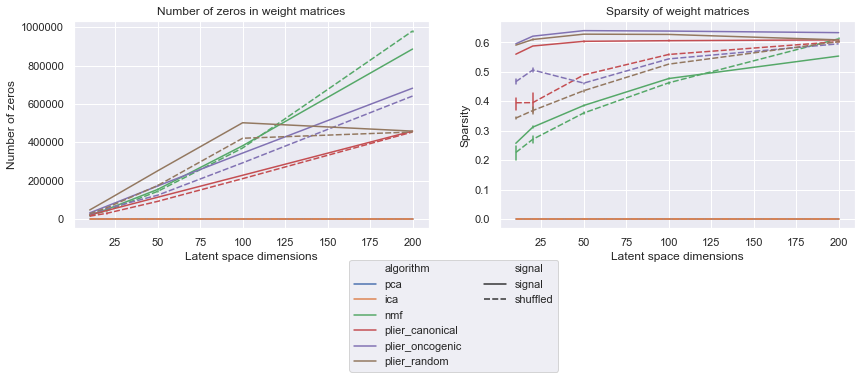

In [3]:
sns.set()
fig, axarr = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(6)
sns.lineplot(data=df, x='z_dim', y='num_zeros', hue='algorithm',
             style='signal', err_style='bars', ax=axarr[0])
axarr[0].set_title('Number of zeros in weight matrices')
axarr[0].set_xlabel('Latent space dimensions')
axarr[0].set_ylabel('Number of zeros')
axarr[0].get_legend().remove()
sns.lineplot(data=df, x='z_dim', y='sparsity', hue='algorithm',
             style='signal', err_style='bars', ax=axarr[1])
axarr[1].set_title('Sparsity of weight matrices')
axarr[1].set_xlabel('Latent space dimensions')
axarr[1].set_ylabel('Sparsity')
axarr[1].get_legend().remove()
handles, labels = axarr[1].get_legend_handles_labels()
fig.subplots_adjust(bottom=0.4)
labels.insert(10, '')
handles.insert(10, handles[0])
labels.insert(11, '')
handles.insert(11, handles[0])
labels.insert(12, '')
handles.insert(12, handles[0])
plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0.45, 0.03), ncol=2)

Next, we want to assess the similarity of the transformations learned by each method, up to affine transform, using [SVCCA](https://arxiv.org/abs/1706.05806).

If PLIER is learning a distinct transformation from the other methods, we would expect the variants of PLIER using different pathway datasets to be more similar to each other than to the other methods.

Note that this is a bit tricky because PLIER operates on a different gene set than the other methods (since PLIER is limited to genes that are present in its pathway dataset). Thus, we take two approaches to comparing transformations on different gene sets:

* **Approach 1**: compare all pairs of weights (transformations) on the subset of genes that are present for all methods
* **Approach 2**: compare each pair of weights on the subset of genes that are present for those two methods

The first approach has the advantage of comparing all methods on the same gene set, but this gene set is relatively small (~2500 genes in our case) and might not be perfectly representative of the signal captured by each of the methods.

The second approach allows comparisons on a larger (and potentially more representative) set of genes, but it compares methods on different gene sets, thus similarity scores might not be perfectly comparable.

In [4]:
import os

import config as cfg
import utilities.latent_space_utilities as lu

z_dims = [10, 20, 50, 100, 200]

models_map = {
    'pca': os.path.abspath(os.path.join(cfg.models_dir, 'canonical_pathways', 'ensemble_z_matrices')),
    'ica': os.path.abspath(os.path.join(cfg.models_dir, 'canonical_pathways', 'ensemble_z_matrices')),
    'nmf': os.path.abspath(os.path.join(cfg.models_dir, 'canonical_pathways', 'ensemble_z_matrices')),
    'plier_canonical': os.path.abspath(os.path.join(cfg.models_dir, 'canonical_pathways', 'ensemble_z_matrices')),
    'plier_oncogenic': os.path.abspath(os.path.join(cfg.models_dir, 'oncogenic_pathways', 'ensemble_z_matrices')),
    'plier_random': os.path.abspath(os.path.join(cfg.models_dir, 'random_pathways', 'ensemble_z_matrices'))
}

avg_cca_mtx = lu.calculate_avg_cca(z_dims, models_map, overlap=False, verbose=True)

Comparing pca with pca for z=10...done
Comparing pca with ica for z=10...done
Comparing pca with nmf for z=10...done
Comparing pca with plier_canonical for z=10...done
Comparing pca with plier_oncogenic for z=10...done
Comparing pca with plier_random for z=10...done
Comparing ica with ica for z=10...done
Comparing ica with nmf for z=10...done
Comparing ica with plier_canonical for z=10...done
Comparing ica with plier_oncogenic for z=10...done
Comparing ica with plier_random for z=10...done
Comparing nmf with nmf for z=10...done
Comparing nmf with plier_canonical for z=10...done
Comparing nmf with plier_oncogenic for z=10...done
Comparing nmf with plier_random for z=10...done
Comparing plier_canonical with plier_canonical for z=10...done
Comparing plier_canonical with plier_oncogenic for z=10...done
Comparing plier_canonical with plier_random for z=10...done
Comparing plier_oncogenic with plier_oncogenic for z=10...done
Comparing plier_oncogenic with plier_random for z=10...done
Compari

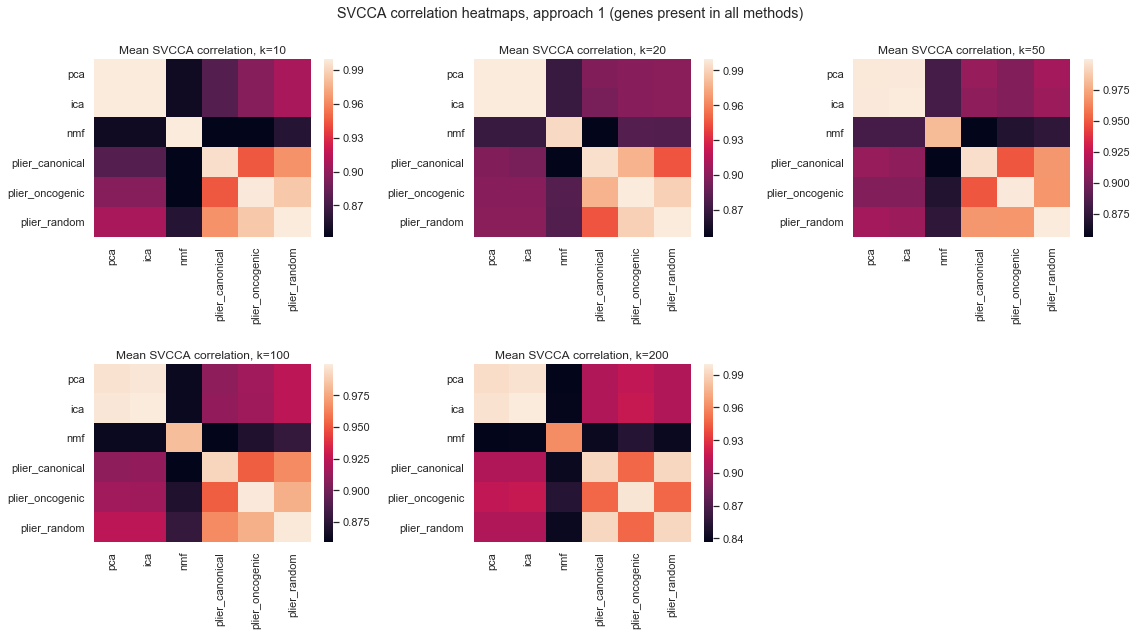

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
fig, axarr = plt.subplots(2, 3)
fig.set_figwidth(16)
fig.set_figheight(9)
fig.delaxes(axarr[1][2])

for ix, z_dim in enumerate(z_dims):
    ax = axarr[ix // 3, ix % 3]
    df = pd.DataFrame(data=avg_cca_mtx[z_dim], index=models_map.keys(), columns=models_map.keys())
    sns.heatmap(df, ax=ax)
    ax.set_title('Mean SVCCA correlation, k={}'.format(z_dim))

plt.tight_layout(h_pad=3)
fig.suptitle('SVCCA correlation heatmaps, approach 1 (genes present in all methods)')
fig.subplots_adjust(top=0.9)

In [6]:
avg_cca_mtx = lu.calculate_avg_cca(z_dims, models_map, overlap=True, verbose=True)

Comparing pca with pca for z=10...done
Comparing pca with ica for z=10...done
Comparing pca with nmf for z=10...done
Comparing pca with plier_canonical for z=10...done
Comparing pca with plier_oncogenic for z=10...done
Comparing pca with plier_random for z=10...done
Comparing ica with ica for z=10...done
Comparing ica with nmf for z=10...done
Comparing ica with plier_canonical for z=10...done
Comparing ica with plier_oncogenic for z=10...done
Comparing ica with plier_random for z=10...done
Comparing nmf with nmf for z=10...done
Comparing nmf with plier_canonical for z=10...done
Comparing nmf with plier_oncogenic for z=10...done
Comparing nmf with plier_random for z=10...done
Comparing plier_canonical with plier_canonical for z=10...done
Comparing plier_canonical with plier_oncogenic for z=10...done
Comparing plier_canonical with plier_random for z=10...done
Comparing plier_oncogenic with plier_oncogenic for z=10...done
Comparing plier_oncogenic with plier_random for z=10...done
Compari

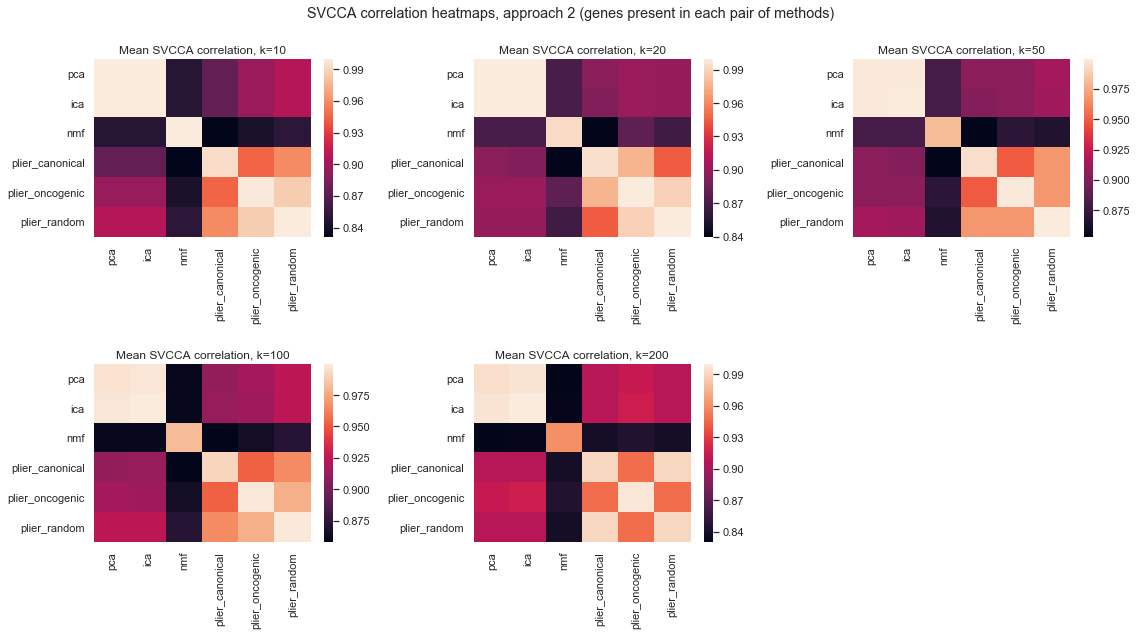

In [7]:
sns.set()
fig, axarr = plt.subplots(2, 3)
fig.set_figwidth(16)
fig.set_figheight(9)
fig.delaxes(axarr[1][2])

for ix, z_dim in enumerate(z_dims):
    ax = axarr[ix // 3, ix % 3]
    df = pd.DataFrame(data=avg_cca_mtx[z_dim], index=models_map.keys(), columns=models_map.keys())
    sns.heatmap(df, ax=ax)
    ax.set_title('Mean SVCCA correlation, k={}'.format(z_dim))

plt.tight_layout(h_pad=3)
fig.suptitle('SVCCA correlation heatmaps, approach 2 (genes present in each pair of methods)')
fig.subplots_adjust(top=0.9)

We also wanted to look at the sparsity of the coefficients in the final classifiers derived from the PCA/NMF/PLIER latent spaces. Are the classifiers resulting from the different latent spaces similar, or noticeably different?

In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import config as cfg

# loop over pathway dirs, genes
# can extract models directly from coefficient dataframes
pathway_dirs = ['canonical_pathways', 'oncogenic_pathways', 'random_pathways']
genes = ['KRAS', 'PIK3CA', 'PTEN', 'TP53', 'TTN']

coef_df = None
for pathway_dir in pathway_dirs:
    for gene in genes:
        coef_file = os.path.join(cfg.results_dir,
                                 pathway_dir,
                                 'mutation',
                                 gene,
                                 '{}_coefficients.tsv.gz'.format(gene))
        df = pd.read_csv(coef_file, sep='\t')
        # replace plier
        plier_corrected = 'plier_{}'.format(pathway_dir.replace('_pathways', ''))
        df['algorithm'] = df['algorithm'].replace('plier', plier_corrected)
        if coef_df is None:
            coef_df = df
        else:
            coef_df = pd.concat((coef_df, df))
            
coef_df.head()

,feature,weight,abs,signal,z_dim,seed,algorithm,gene
0,pca_16,-0.30161,0.30161,signal,20,671155,pca,KRAS
1,pca_11,-0.19030,0.19030,signal,20,671155,pca,KRAS
2,pca_6,0.17216,0.17216,signal,20,671155,pca,KRAS
3,pca_9,-0.16071,0.16071,signal,20,671155,pca,KRAS
4,pca_8,-0.15131,0.15131,signal,20,671155,pca,KRAS


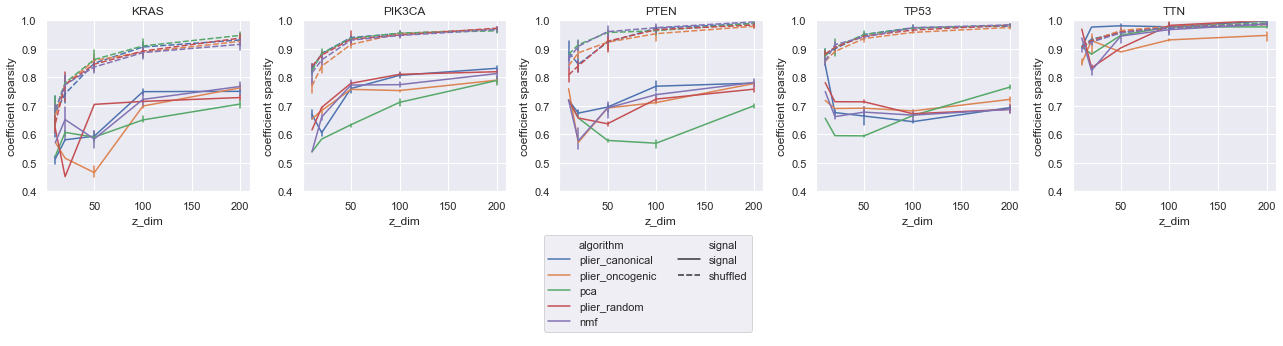

In [56]:
sns.set()
fig, axarr = plt.subplots(1, len(genes))
fig.set_figwidth(18)
fig.set_figheight(5)

for ix, gene in enumerate(genes):
    df = coef_df[coef_df['gene'] == gene]
    sparsity_df = (
        df.drop(columns=['gene', 'feature', 'abs'])
          .groupby(['algorithm', 'signal', 'seed', 'z_dim'])
          .agg(lambda x: x.eq(0).sum() / x.count())
          .reset_index()
          .rename({'weight': 'sparsity'}, axis='columns')
          .sort_values(by='signal', ascending=False)
    )
    ax = axarr[ix]
    sns.lineplot(data=sparsity_df, x='z_dim', y='sparsity', hue='algorithm',
                 style='signal', err_style='bars', ax=ax)
    ax.set_ylabel('coefficient sparsity')
    ax.set_ylim((0.4, 1.0))
    ax.get_legend().remove()
    ax.set_title(gene)
    if ix == len(genes)-1:
        handles, labels = ax.get_legend_handles_labels()

plt.tight_layout(h_pad=2)
fig.subplots_adjust(bottom=0.45)
labels.insert(9, '')
handles.insert(9, handles[0])
labels.insert(10, '')
handles.insert(10, handles[0])
plt.figlegend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.025), ncol=2)